# GEOG 313 Final




Function 1: Read in Sentinel-1 SAR 

	- Inputs: AOI, date range 
	- Outputs: Median quarterly composites (mosaiced) of VH and VV bands 

Function 2: Create index time series 

	- Inputs: median quarterly composites, name of index (RVI, mRFDI) 
	- Outputs: time series of index value 

Function 3: Create Visualizations within subzones 

	- Inputs: time series, subzones 
	- outputs: graph of index value vs time for each subzone. 

Function 4: Visualize trends 

	- Inputs: time series, name of trend (linear, monotonic, etc) 
	- outputs: raster image of correlation coefficient or other values (depending on what trend is used- ex. for linear trend it would output two images, r value and correlation coefficient) 

Function 5: detect deforestation 

	- Inputs: time series, index threshold value 
	- outputs: image of what year deforestation occurred (when value decreased below the user-defined threshold. If the value decreased then increased the result will be inconclusive and marked with an appropriate value) 



In [1]:
import dask
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
client = Client(cluster)
print(client.dashboard_link)

http://127.0.0.1:8787/status


In [70]:
#aoi = [38.5899868, -4.9244565, 38.6700000, -4.8470000]

#aoi1 = [38.6579757, -4.9221954, 38.5899868, -4.8995308]

start = "2015-01-01"
end = "2024-12-31"

bands = ["VV", "VH"]

In [77]:
import leafmap

m = leafmap.Map(center=[-5.0467299, 38.7375924], zoom=17, height="800px", google_map="SATELLITE")
m


Map(center=[-5.0467299, 38.7375924], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title…

In [96]:
aoi = (m.west, m.south, m.east, m.north)

In [97]:
search = get_sar_pc(aoi, start, end)

In [98]:

stack = stackstac.stack(
    search,
    epsg=32737,
    resolution=20,
    bounds_latlon=aoi,
    )

#stack.time.plot.hist(bins = 10)
stack

<xarray.DataArray 'stackstac-abcee70da1095f499b1d16d2bca94068' (time: 291,
                                                                band: 2, y: 4,
                                                                x: 7)> Size: 130kB
dask.array<fetch_raster_window, shape=(291, 2, 4, 7), dtype=float64, chunksize=(1, 1, 4, 7), chunktype=numpy.ndarray>
Coordinates: (12/39)
  * time                                   (time) datetime64[ns] 2kB 2015-01-...
    id                                     (time) <U66 77kB 'S1A_IW_GRDH_1SDV...
  * band                                   (band) <U2 16B 'vh' 'vv'
  * x                                      (x) float64 56B 4.71e+05 ... 4.711...
  * y                                      (y) float64 32B 9.442e+06 ... 9.44...
    sar:polarizations                      object 8B {'VV', 'VH'}
    ...                                     ...
    proj:epsg                              int64 8B 32737
    sat:platform_international_designator  (time) <U9 10kB '0000-000A' ... '2...
    title                                  (band) <U41 328B 'VH: vertical tra...
    description                            (band) <U173 1kB 'Terrain-correcte...
    raster:bands                           object 8B {'nodata': -32768, 'data...
    epsg                                   int64 8B 32737
Attributes:
    spec:        RasterSpec(epsg=32737, bounds=(470980, 9442100, 471120, 9442...
    crs:         epsg:32737
    transform:   | 20.00, 0.00, 470980.00|\n| 0.00,-20.00, 9442180.00|\n| 0.0...
    resolution:  20

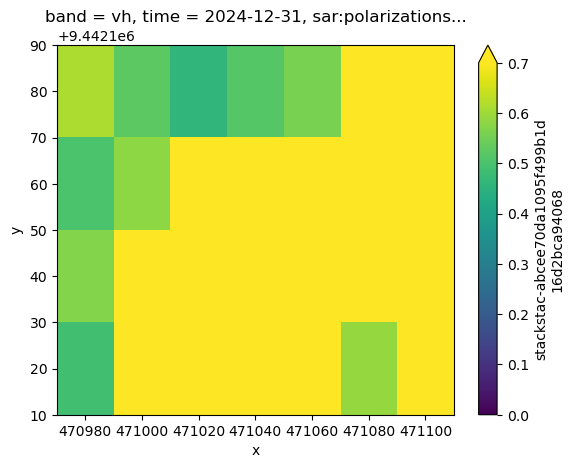

In [99]:
q_composite = quartely_composite(stack)
q_composite

index = calculate_index(q_composite, "RVI")

# TO do- values within subzones
#index.isel(time=0).plot.imshow()



index.isel(time=-1).plot.imshow(vmin=0, vmax=0.7)

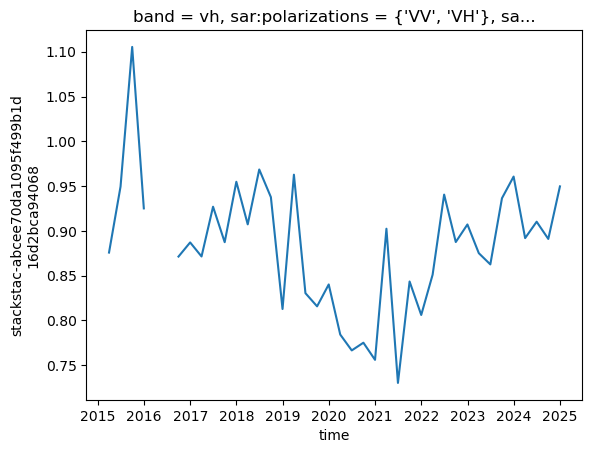

In [100]:
tsmean = index.mean(dim = ['y', 'x'], skipna = True) 

tsmean.plot()
# fig, ax = plt.subplots()
# tsmean.plot.scatter(ax=ax)
# plt.draw()

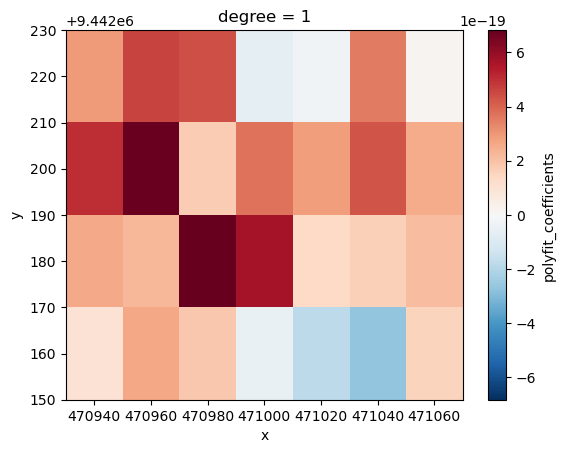

In [89]:
trends = linear_trend(index)
linecoeff = trends.sel(degree = 1)

linecoeff.polyfit_coefficients.plot.imshow()

In [4]:
import xarray as xr
import rioxarray as rxr
import numpy as np
import stackstac
import os
import leafmap
import requests
from tqdm import tqdm
import pystac_client
import planetary_computer
from matplotlib import pyplot as plt

# write function to get bbox for polygons


def get_sar_pc(bbox, start, end):

    catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",  # connect to Planetary Computer API
    modifier=planetary_computer.sign_inplace,               
    )

    search = catalog.search(filter_lang="cql2-json", filter={
        "op": "and",
        "args": [{"op": "s_intersects", "args": [{"property": "geometry"}, aoi]},
                 {"op": "=", "args": [{"property": "collection"}, "sentinel-1-rtc"]},
                 {"op": "anyinteracts", "args": [{"property": "datetime"}, f"{start}/{end}"]},
                 {"op": "=", "args": [{"property": "sar:polarizations"}, ["VV", "VH"]]}
                ]
    }
                           )

    items = search.get_all_items()  # get items into new variable
    return items


def items_to_xarray(items, bands):
    stack = stackstac.stack(
        items,                 # output of item collection search
   #     bounds_latlon=bbox,       # clip to bbox
        assets=bands           # get only green and nir bands
    )
    
    return stack

def quartely_composite(stack):
    composite = stack.resample(time="1Q").median("time")

    return composite

def calculate_index(stack, index):
    vh, vv = stack.sel(band = "vh"), stack.sel(band = "vv")

    if index == "mRFDI":
        value = (vv-vh)/(vv+vh)
        return value
    elif index == "RVI":
        value = (4*vh)/(vv+vh)
        return value
    else:
        print("Invalid index name- please choose mRFDI, or RVI")

def linear_trend(stack):
    trend = stack.polyfit(dim = "time", deg = 1)
    return trend

    